# Emotion classification project

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import joblib

import librosa as lr
import librosa.feature as lrf
import librosa.display as lrd

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import scipy.stats as sst

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, concatenate, Normalization

import keras_tuner as kt
from keras_tuning import build_optimized_model

from utils import plot_metrics, img_scaler, scaler, PlotMetrics, KerasModelProgress, time_taken, sklearn_cv, keras_cv, get_folds
from process_data import get_processed
from time import time

np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format

test_path='speech-emotion-recognition-ravdess-data/Actor_08/03-01-07-02-01-01-08.wav'

## Scikit-learn model building

In [3]:
path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
targets = [int(path.split('-')[6]) for path in path_list]

X_train_paths, X_test_paths = train_test_split(path_list, stratify=targets, test_size=0.10, random_state=42)

### Augmentation or no augmentation?

In [ ]:
names = ['LogisticRegression', 'SVC_RBF', 'SVC_linear', 'SVC_poly', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']

aug_clfs = [make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='liblinear')),
            make_pipeline(StandardScaler(), SVC(kernel='rbf')),
            make_pipeline(StandardScaler(), SVC(kernel='linear')),
            make_pipeline(StandardScaler(), SVC(kernel='poly')),
            make_pipeline(RandomForestClassifier()),
            make_pipeline(StandardScaler(), MLPClassifier()),
            make_pipeline(XGBClassifier(tree_method='gpu_hist', objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, n_jobs=1))]

n_augs = [0, 1, 3, 5, 7]

scores = {}

for n_aug in n_augs:
    
    print(f'\nCross-validation using {n_aug} augmentations\n')    
    
    t = time()
    cv_scores = sklearn_cv(aug_clfs, names, X_train_paths, n_folds=5, n_augmentations=n_aug)
    print(f'\nCV done, took time {time_taken(t, True)}')
    
    scores = scores|cv_scores

joblib.dump(pd.DataFrame.from_dict(scores), 'results/AugmentationResults')

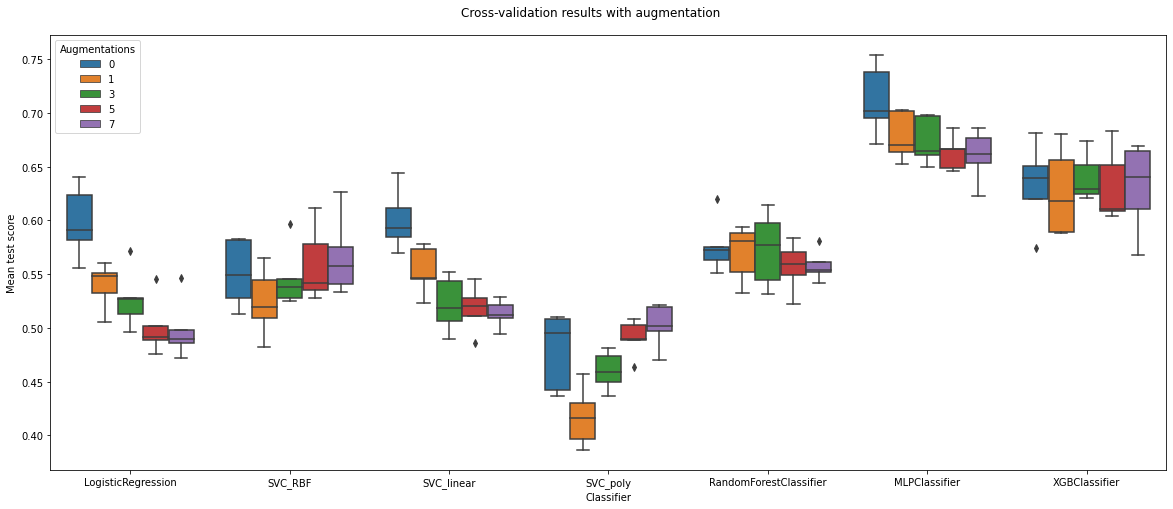

In [2]:
scores = pd.melt(joblib.load('results/AugmentationResults'), var_name=['Classifier', 'Augmentations'], value_name='Mean test score')

plt.figure(figsize=(20, 8))
sns.boxplot(data=scores, x='Classifier', y='Mean test score', hue='Augmentations')
plt.suptitle('Cross-validation results with augmentation', y=0.93)
plt.show()

### Cross-validation of default sklearn classifiers

In [ ]:
X_train, y_train = get_processed(X_train_paths)
X_test, y_test = get_processed(X_test_paths)

joblib.dump(X_train, 'data/X_train'), joblib.dump(X_test, 'data/X_test')
joblib.dump(y_train, 'data/y_train'), joblib.dump(y_test, 'data/y_test')

In [4]:
X_train, y_train = joblib.load('data/X_train'), joblib.load('data/y_train')

target_labels = ['neutral',
                 'calm',
                 'happy',
                 'sad',
                 'angry',
                 'fearul',
                 'disgust',
                 'surprised']

for i in [X_train, y_train]:
    print(i.shape)
    
print(f'\nTrain set target label distribution:\n{pd.DataFrame(y_train).value_counts(normalize=True).sort_index()}\n')

(1296, 171)
(1296,)

Train set target label distribution:
0   0.0664
1   0.1335
2   0.1335
3   0.1335
4   0.1335
5   0.1335
6   0.1335
7   0.1327
dtype: float64



In [11]:
%%time

default_classifiers = [make_pipeline(StandardScaler(), LogisticRegression()),
                       make_pipeline(StandardScaler(), SVC()),
                       make_pipeline(RandomForestClassifier()),
                       make_pipeline(StandardScaler(), MLPClassifier()),
                       make_pipeline(XGBClassifier(tree_method='gpu_hist', objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, n_jobs=1))]

default_results = {}

for clf in default_classifiers:
    
    name = clf[-1].__class__.__name__
    print(f'Fitting estimator {name} with deafult parameters\n')
        
    t = time()
    result = cross_val_score(clf, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, cv=10)
    time_taken(t, True)

    default_results[('Default', name)] = result

joblib.dump(pd.DataFrame(default_results), 'results/DefaultResults')

Fitting estimator LogisticRegression with deafult parameters



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting estimator SVC with deafult parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting estimator RandomForestClassifier with deafult parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting estimator MLPClassifier with deafult parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.9s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting estimator XGBClassifier with deafult parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   47.5s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   47.7s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   48.5s remaining:   20.7s


Wall time: 1min 11s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   59.0s finished


['results/DefaultResults']

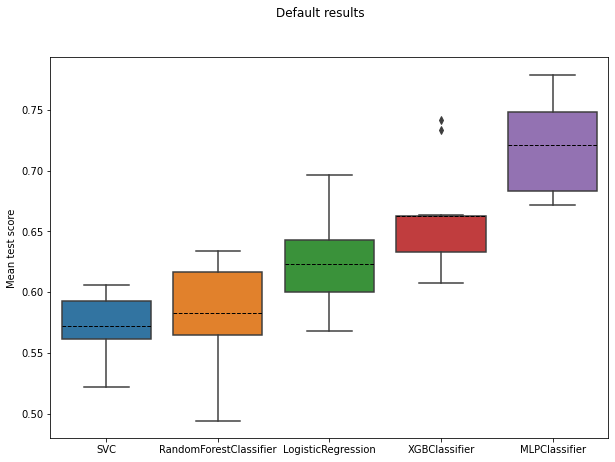


=====Cross-validation metrics======

With estimator: MLPClassifier

Mean F1-score: 0.721
Standard deviation: 0.037

============== END ===============


=====Cross-validation metrics======

With estimator: XGBClassifier

Mean F1-score: 0.663
Standard deviation: 0.041

============== END ===============


=====Cross-validation metrics======

With estimator: LogisticRegression

Mean F1-score: 0.623
Standard deviation: 0.036

============== END ===============


=====Cross-validation metrics======

With estimator: RandomForestClassifier

Mean F1-score: 0.583
Standard deviation: 0.039

============== END ===============


=====Cross-validation metrics======

With estimator: SVC

Mean F1-score: 0.572
Standard deviation: 0.024

============== END ===============



In [4]:
default_results = joblib.load('results/DefaultSklearnResults')['Default']

sorted_names = default_results.mean().sort_values().index

sorted_default_results = default_results[sorted_names]

plt.figure(figsize=(10,7))

sns.boxplot(data=sorted_default_results, medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})
plt.ylabel('Mean test score')
plt.xlabel(None)
plt.suptitle('Default results')
plt.show()

for name in np.flip(sorted_names):
    
    score = np.mean(default_results[name])
    std = np.std(default_results[name])
    
    print('\n=====Cross-validation metrics======\n')
    print(f'With estimator: {name}\n')
    print(f"Mean F1-score: {round(score, 3)}")
    print(f"Standard deviation: {round(std, 3)}\n")
    print('============== END ===============\n')
    

### Hyperparameter search results

In [14]:
names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']
paths = [('searches/'+name+'Search', 'searches/'+name+'Results') for name in names]

searches, results = [], []

for p1, p2 in paths:
    searches.append(joblib.load(p1))
    results.append(joblib.load(p2))

In [15]:
columns_to_show = ['mean_test_score', 'std_test_score', 'rank_test_score', 'n_samples', 'params']

for i, name in enumerate(names):
    
    sorted_results = results[i][['mean_test_score', 'std_test_score', 'rank_test_score', 'n_samples', 'params']].sort_values(['mean_test_score'], ascending=False)
    
    with pd.option_context('display.max_colwidth', -1):
        print('\nTop 3 best performing parameters for model: '+name)
        display(sorted_results[:3])


Top 3 best performing parameters for model: LogisticRegression


,mean_test_score,std_test_score,rank_test_score,n_samples,params
334,0.6188,0.0162,1,1296,"{'clf__C': 5.182323505895209, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"
125,0.6183,0.0175,2,1296,"{'clf__C': 5.1096007572985185, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"
529,0.6176,0.0137,3,1296,"{'clf__C': 5.642107090110922, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"



Top 3 best performing parameters for model: SVC


,mean_test_score,std_test_score,rank_test_score,n_samples,params
3913,0.7375,0.0303,1,1296,"{'clf__C': 4.073181932046468, 'clf__gamma': 1.0070740558594764, 'clf__kernel': 'rbf', 'decomp': PCA(n_components=0.99), 'scaler2': MinMaxScaler()}"
3059,0.7348,0.0212,2,1296,"{'clf__C': 3.7389329023788513, 'clf__gamma': 0.015317140891398554, 'clf__kernel': 'rbf', 'decomp': PCA(n_components=0.99), 'scaler2': StandardScaler()}"
1745,0.7304,0.0216,3,1296,"{'clf__C': 9.812414648924417, 'clf__gamma': 0.0054615296005484995, 'clf__kernel': 'rbf', 'decomp': PCA(), 'scaler2': 'passthrough'}"



Top 3 best performing parameters for model: RandomForestClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
534,0.6407,0.0225,1,1296,"{'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__max_features': 30, 'clf__criterion': 'entropy', 'clf__bootstrap': False}"
779,0.6367,0.0245,2,1296,"{'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__max_features': 31, 'clf__criterion': 'entropy', 'clf__bootstrap': False}"
236,0.6341,0.0336,3,1296,"{'clf__n_estimators': 500, 'clf__min_samples_split': 4, 'clf__max_features': 27, 'clf__criterion': 'entropy', 'clf__bootstrap': False}"



Top 3 best performing parameters for model: MLPClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
66,0.7416,0.0318,1,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 1000, 'clf__learning_rate_init': 0.0005, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512, 128), 'clf__batch_size': 100, 'clf__activation': 'relu'}"
50,0.7385,0.0213,2,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 1000, 'clf__learning_rate_init': 0.0005, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512,), 'clf__batch_size': 100, 'clf__activation': 'relu'}"
70,0.7374,0.0294,3,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 1000, 'clf__learning_rate_init': 0.0005, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512, 64), 'clf__batch_size': 100, 'clf__activation': 'relu'}"



Top 3 best performing parameters for model: XGBClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
1897,0.6654,0.0296,1,1296,"{'clf__colsample_bytree': 0.9007123166538439, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.06126780910439317, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.7671253776764335, 'clf__tree_method': 'gpu_hist'}"
227,0.6638,0.0327,2,1296,"{'clf__colsample_bytree': 0.7886879685162956, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.011689319600720813, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.5318214214489826, 'clf__tree_method': 'gpu_hist'}"
241,0.6630,0.0249,3,1296,"{'clf__colsample_bytree': 0.5924101307502787, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.002617805884371923, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.6181436488221598, 'clf__tree_method': 'gpu_hist'}"


### Cross-validation of tuned sklearn classifiers

In [16]:
%%time

optimized_results = {}

for i, name in enumerate(names):
    
    print(f'Fitting model {name} with best parameters\n')
    
    opt_estimator = searches[i][-1].best_estimator_
        
    t = time()
    result = cross_val_score(opt_estimator, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, cv=10)
    time_taken(t, True)

    optimized_results[name, 'Optimized'] = result

joblib.dump(pd.DataFrame(optimized_results), 'results/OptimizedResults')

Fitting model LogisticRegression with best parameters



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   15.4s remaining:   36.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   17.1s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   17.4s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting model SVC with best parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting model RandomForestClassifier with best parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.6min remaining:   39.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting model MLPClassifier with best parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   46.2s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   48.3s remaining:   48.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   49.7s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting model XGBClassifier with best parameters



[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.4min remaining:   37.1s


Wall time: 5min 41s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


['results/OptimizedResults']

### Final fit

In [66]:
%%time

best_classifiers = [searches[i][-1].best_estimator_ for i in range(len(names))]

for clf in best_classifiers:
    
    print(f'Fitting estimator {clf[-1].__class__.__name__}\n')
    clf.fit(X_train, y_train)
    
    joblib.dump(clf, 'models/'+clf[-1].__class__.__name__)

Fitting estimator LogisticRegression

Fitting estimator SVC

Fitting estimator RandomForestClassifier

Fitting estimator MLPClassifier

Fitting estimator XGBClassifier

Wall time: 1min 38s


## Keras convolutional neural network

### Creating traning, validation and test data

In [2]:
%%time

path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
path_targets = [int(path.split('-')[6]) for path in path_list]

X_paths, X_test_paths = train_test_split(path_list, stratify=path_targets, test_size=0.10, random_state=42)
X_train_paths, X_val_paths = train_test_split(X_paths, stratify=[int(path.split('-')[6]) for path in X_paths], test_size=0.10)

X_train_keras, y_train_keras = get_processed(X_train_paths, n_masks=3, for_sklearn=False, n_mels=128)
X_val_keras, y_val_keras = get_processed(X_val_paths, for_sklearn=False, n_mels=128)
X_test_keras, _ = get_processed(X_test_paths, for_sklearn=False, n_mels=128)

y_train_keras = keras.utils.to_categorical(y_train_keras, 8)
y_val_keras = keras.utils.to_categorical(y_val_keras, 8)

joblib.dump(X_train_keras, 'data/X_train_keras'), joblib.dump(X_val_keras, 'data/X_val_keras'), joblib.dump(X_test_keras, 'data/X_test_keras')
joblib.dump(y_train_keras, 'data/y_train_keras'), joblib.dump(y_val_keras, 'data/y_val_keras')

Wall time: 53.4 ms


In [154]:
X_train_keras, X_val_keras = joblib.load('data/X_train_keras'), joblib.load('data/X_val_keras')
X_keras, X_test_keras = joblib.load('data/X_keras'), joblib.load('data/X_test_keras')

y_train_keras, y_val_keras = joblib.load('data/y_train_keras'), joblib.load('data/y_val_keras')

X_train_keras[1], (X_val_keras[1], X_test_keras[1]) = scaler(X_train_keras[1], [X_val_keras[1], X_test_keras[1]])

X_keras = [np.vstack((a, b)) for a, b in zip(X_train_keras, X_val_keras)]
y_keras = np.vstack((y_train_keras, y_val_keras))

print('Feature shapes:\n')
print('Mfcc: ', X_train_keras[0].shape[1:])
print('Mel data: ', X_train_keras[1].shape[1:])
print('Metadata: ', X_train_keras[2].shape[1:], '\n')

print('Set sizes: \n')
print('X_keras (X_train + X_val): ', X_keras[1].shape[0])
print('X_train: ', X_train_keras[1].shape[0])
print('X_val: ', X_val_keras[1].shape[0])
print('X_test: ', X_test_keras[1].shape[0])


Feature shapes:

Mfcc:  (20, 69, 1)
Mel data:  (256,)
Metadata:  (3,) 

Set sizes: 

X_keras (X_train + X_val):  4794
X_train:  4664
X_val:  130
X_test:  144


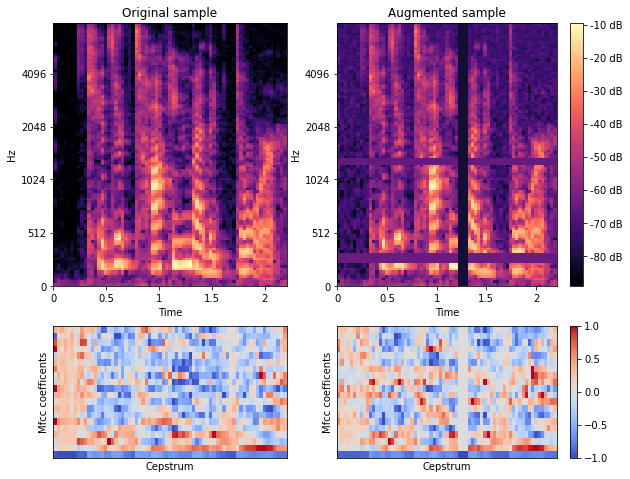

In [8]:
test_path=['speech-emotion-recognition-ravdess-data/Actor_08/03-01-07-01-01-01-08.wav']

sample, _ = get_processed(test_path, n_masks=1, for_sklearn=False, n_mels=128, full_mels=True)

fig, axs = plt.subplots(2,2, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 0.5], 'width_ratios': [0.85, 1]}, sharey=False)

mel = lrd.specshow(sample[1][0].reshape(128, 69), y_axis='mel', x_axis='time', ax=axs[0,0], sr=16000)
axs[0,0].set_title('Original sample')

mfcc = lrd.specshow(lr.util.normalize(sample[0][0][:,:,0], axis=1), ax=axs[1,0], sr=16000)
axs[1,0].set_xlabel('Cepstrum')
axs[1,0].set_ylabel('Mfcc coefficents')

mel = lrd.specshow(sample[1][1].reshape(128, 69), y_axis='mel', x_axis='time', ax=axs[0,1], sr=16000)
fig.colorbar(mel, ax=axs[0,1], format="%+2.f dB")
axs[0,1].set_title('Augmented sample')

mfcc = lrd.specshow(lr.util.normalize(sample[0][1][:,:,0], axis=1), ax=axs[1,1], sr=16000)
fig.colorbar(mfcc, ax=axs[1,1])
axs[1,1].set_xlabel('Cepstrum')
axs[1,1].set_ylabel('Mfcc coefficents')

plt.show()

### Default Keras classfier

In [12]:
def build_default_model():
    
    input1 = Input((20, 69, 1))
    
    x1 = Conv2D(32, 3, activation='relu', padding='same')(input1)
    x1 = Conv2D(32, 3, activation='relu', padding='same')(x1)
    x1 = MaxPooling2D(pool_size=(3,3))(x1)

    x1 = Conv2D(64, 3, activation='relu', padding='same')(x1)
    x1 = Conv2D(64, 3, activation='relu', padding='same')(x1)
    x1 = MaxPooling2D(pool_size=(3,3))(x1)

    flat1 = Flatten()(x1)
    flat1 = Dropout(0.5)(flat1)
    
    input2 = Input((256,))
    
    input3 = Input((3,))
    
    x2 = concatenate([input2, input3])
    
    x2 = Dense(64, activation='relu')(x2)
        
    merge = concatenate([flat1, x2])

    x = Dense(256, activation='relu')(merge)
    x = Dropout(0.5)(x)
    
    output = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
                      
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [9]:
default_keras = build_default_model()

default_keras.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 20, 69, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 20, 69, 32)   320         ['input_7[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 20, 69, 32)   9248        ['conv2d_8[0][0]']               
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 6, 23, 32)   0           ['conv2d_9[0][0]']               
                                                                                            

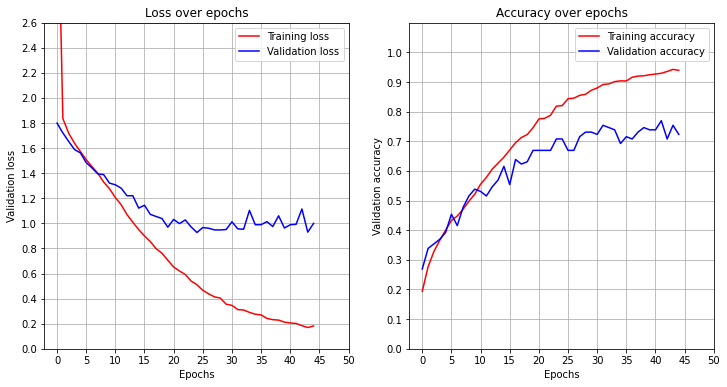

600/600 [==============================] - 6s 10ms/step - loss: 0.5105 - accuracy: 0.8229


['results/DefaultConv2DHistory']

In [10]:
def scheduler(epoch, lr):
    if epoch == 50 or epoch == 70 or epoch == 90:
        return lr*0.5
    else:
        return lr

default_history = default_keras.fit([X_train_keras[0], X_train_keras[1], X_train_keras[2]], y_train_keras,
                                    batch_size=8, epochs=120,
                                    validation_data=([X_val_keras[0], X_val_keras[1], X_val_keras[2]], y_val_keras),
                                    shuffle=True,
                                    callbacks=[keras.callbacks.EarlyStopping(patience=20, min_delta=0.0001, restore_best_weights=True),
                                               keras.callbacks.LearningRateScheduler(scheduler),
                                               PlotMetrics()])

default_keras.fit([X_keras[0], X_keras[1], X_keras[2]], y_keras, epochs=1, batch_size=8)

default_keras.save('models/DefaultConv2DClassifier.h5')

joblib.dump(default_history.history, 'results/DefaultConv2DHistory')

#### Cross-validation

In [ ]:
path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
path_targets = [int(path.split('-')[6]) for path in path_list]

X_paths, _ = train_test_split(path_list, stratify=path_targets, test_size=0.10, random_state=42)

default_cv_scores = {}

t = time()
f1s, losses = keras_cv(build_default_model, hp=None, train_paths=X_paths, n_augmentations=3, n_folds=3, epochs=70, n_msgs=6)
print(f'\nCV done, took time {time_taken(t, True)}')

default_cv_scores['F1'] = f1s
default_cv_scores['Loss'] = losses

joblib.dump(pd.DataFrame(default_cv_scores), 'results/DefaultKerasCVResults')

### Optimized Keras classifier

In [ ]:
tuner = kt.BayesianOptimization(build_optimized_model, objective='val_loss', max_trials=250, num_initial_points=50,                                 
                                    directory = 'keras/search')

best_hps = [hp for hp in tuner.get_best_hyperparameters(num_trials=20)]
joblib.dump(best_hps, 'searches/KerasHPs')

In [150]:
best_hps = joblib.load('keras/KerasHPs')
pd.DataFrame([hp.values for hp in best_hps]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
filters1,32,96,32,64,96,32,32,96,32,64,96,32,32,32,32,64,32,64,96,64
batchnorm1,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True
dropout1,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2000
filters2,32,32,32,32,32,32,32,32,32,32,64,32,32,32,32,32,32,32,32,96
dropout2,0.3000,0.4000,0.4000,0.0000,0.0000,0.4000,0.0000,0.5000,0.3000,0.0000,0.5000,0.5000,0.4000,0.0000,0.0000,0.5000,0.2000,0.0000,0.0000,0.5000
filters3,192,192,192,64,128,192,64,192,192,64,64,64,96,64,64,64,192,64,128,96
batchnorm2,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,True
dropout3,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000,0.1000,0.0000,0.0000,0.1000,0.1000,0.0000,0.0000,0.2000
filters4,192,128,128,96,96,128,64,128,192,96,96,96,64,96,64,96,192,96,64,64
dropout4,0.7500,0.5562,0.6552,0.7500,0.7080,0.5194,0.7500,0.4635,0.7500,0.7500,0.2649,0.3542,0.4224,0.7500,0.7500,0.3780,0.7382,0.7500,0.7500,0.2439


In [3]:
optimized_keras = build_optimized_model(best_hps[0])

optimized_keras.summary()

Model: "OptimizedConv2D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 69, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 20, 69, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 69, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 20, 69, 32)   9248        ['batch_normalizati

In [ ]:
plot_model(optimized_keras, show_shapes=True, dpi=96, to_file='keras/KerasClassifierGraph.png')

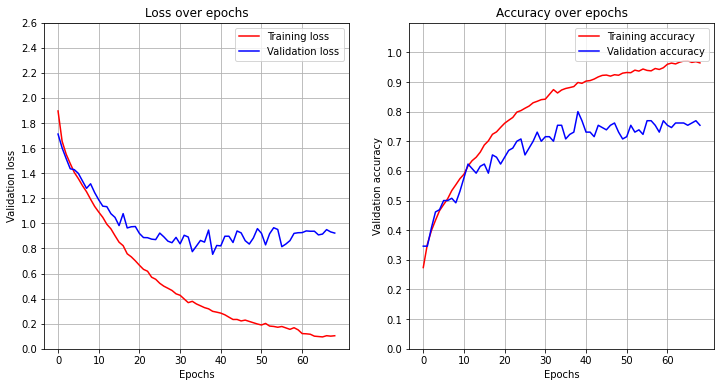

600/600 [==============================] - 8s 13ms/step - loss: 0.2851 - accuracy: 0.9026


In [7]:
def scheduler(epoch, lr):
    if epoch == 50 or epoch == 70 or epoch == 90:
        return lr*0.5
    else:
        return lr

optimized_history = optimized_keras.fit([X_train_keras[0], X_train_keras[1], X_train_keras[2]], y_train_keras,
                                         validation_data=([X_val_keras[0], X_val_keras[1], X_val_keras[2]], y_val_keras),
                                         batch_size=8, epochs=110, shuffle=True,
                                         callbacks=[keras.callbacks.LearningRateScheduler(scheduler),
                                                    PlotMetrics()])

optimized_keras.fit([X_keras[0], X_keras[1], X_keras[2]], y_keras, epochs=1, batch_size=8)

optimized_keras.save('models/OptimizedConv2DClassifier.h5')

joblib.dump(optimized_history.history, 'results/OptimizedConv2DHistory')

#### Cross-validation

In [ ]:
%%time

path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
path_targets = [int(path.split('-')[6]) for path in path_list]

X_paths, _ = train_test_split(path_list, stratify=path_targets, test_size=0.10, random_state=42)

best_hps = joblib.load('keras/KerasHPs')

epoch_list = [50, 60, 70, 80, 90, 100, 110, 120, 130]

f1_scores = {}
losses_dict = {}

for epoch in epoch_list:
    
    print(f'\nCross-validation using {epoch} epochs\n')
    
    t = time()
    f1s, losses = keras_cv(build_optimized_model, best_hps[0], X_paths, n_augmentations=3, n_folds=10, epochs=epoch, n_msgs=6)
    print(f'\nCV done, took time {time_taken(t, True)}')
    
    print('\n============= END ==============')
    
    f1_scores[epoch] = f1s
    losses_dict[epoch] = losses
        
joblib.dump([pd.DataFrame(f1_scores), pd.DataFrame(losses_dict)], 'results/OptimizedKerasCVResults')

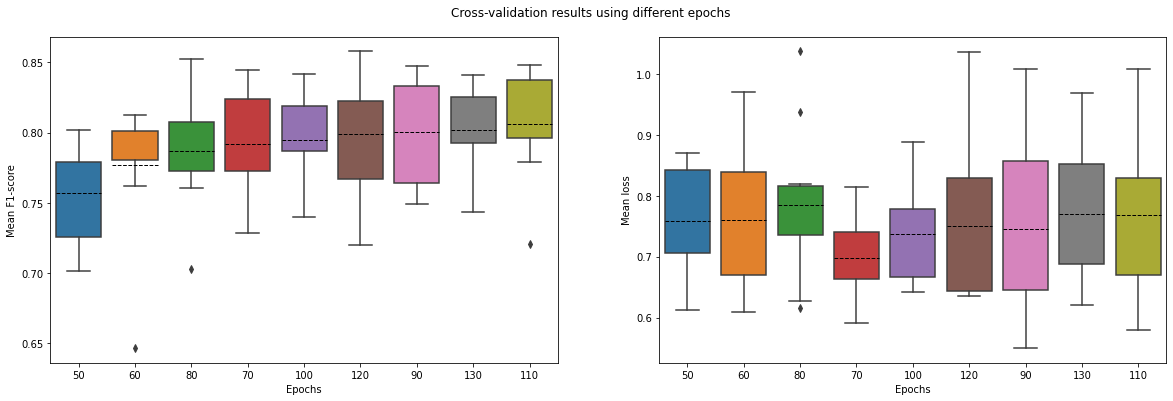


==== Cross-validation metrics =====

Using 110 epochs

Mean F1-score: 0.806
Standard deviation: 0.036

Mean loss: 0.769
Standard deviation: 0.123

============== END ===============


==== Cross-validation metrics =====

Using 130 epochs

Mean F1-score: 0.802
Standard deviation: 0.029

Mean loss: 0.77
Standard deviation: 0.108

============== END ===============


==== Cross-validation metrics =====

Using 90 epochs

Mean F1-score: 0.8
Standard deviation: 0.035

Mean loss: 0.745
Standard deviation: 0.14

============== END ===============


==== Cross-validation metrics =====

Using 120 epochs

Mean F1-score: 0.799
Standard deviation: 0.039

Mean loss: 0.75
Standard deviation: 0.125

============== END ===============


==== Cross-validation metrics =====

Using 100 epochs

Mean F1-score: 0.795
Standard deviation: 0.03

Mean loss: 0.737
Standard deviation: 0.088

============== END ===============


==== Cross-validation metrics =====

Using 70 epochs

Mean F1-score: 0.792
Standard de

In [5]:
f1s, losses = joblib.load('results/OptimizedKerasCVResults')

sorted_ = f1s.mean().sort_values().index

sorted_f1s = f1s[sorted_]
sorted_losses = losses[sorted_]

fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

sns.boxplot(data=sorted_f1s, ax=ax1, medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})
ax1.set_ylabel('Mean F1-score')
ax1.set_xlabel('Epochs')

sns.boxplot(data=sorted_losses, ax=ax2, medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})
ax2.set_ylabel('Mean loss')
ax2.set_xlabel('Epochs')

plt.suptitle('Cross-validation results using different epochs', y=0.95)
plt.show()

for epoch in np.flip(sorted_):
    
    f1 = np.mean(f1s[epoch])
    f1_std = np.std(f1s[epoch])
    
    loss = np.mean(losses[epoch])
    loss_std = np.std(losses[epoch])
    
    print('\n==== Cross-validation metrics =====\n')
    print(f'Using {epoch} epochs\n')
    print(f"Mean F1-score: {round(f1, 3)}")
    print(f"Standard deviation: {round(f1_std, 3)}\n")
    print(f"Mean loss: {round(loss, 3)}")
    print(f"Standard deviation: {round(loss_std, 3)}\n")
    print('============== END ===============\n')

## Final evaluation for all classifiers

### Cross-validation results

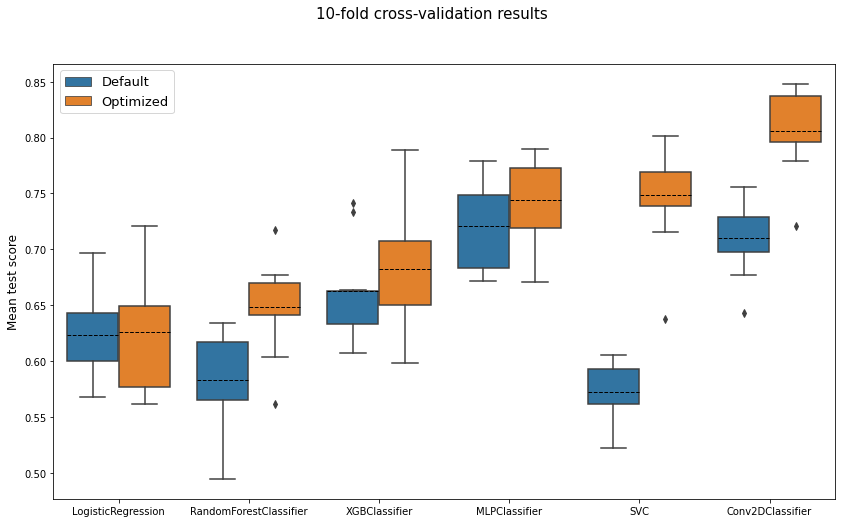


==== Cross-validation metrics ====

With estimator: Conv2DClassifier

Mean F1-score: 0.806
Standard deviation: 0.036

============== END ================


==== Cross-validation metrics ====

With estimator: SVC

Mean F1-score: 0.749
Standard deviation: 0.044

============== END ================


==== Cross-validation metrics ====

With estimator: MLPClassifier

Mean F1-score: 0.744
Standard deviation: 0.037

============== END ================


==== Cross-validation metrics ====

With estimator: XGBClassifier

Mean F1-score: 0.682
Standard deviation: 0.05

============== END ================


==== Cross-validation metrics ====

With estimator: RandomForestClassifier

Mean F1-score: 0.648
Standard deviation: 0.04

============== END ================


==== Cross-validation metrics ====

With estimator: LogisticRegression

Mean F1-score: 0.626
Standard deviation: 0.052

============== END ================



In [7]:
default_cv, optimized_cv = joblib.load('results/DefaultSklearnResults'), joblib.load('results/OptimizedSklearnResults')
default_keras_cv, optimized_keras_cv = joblib.load('results/DefaultKerasCVResults'), joblib.load('results/OptimizedKerasCVResults')[0]

default_cv[('Default', 'Conv2DClassifier')] = default_keras_cv['F1']
optimized_cv[('Optimized', 'Conv2DClassifier')] = optimized_keras_cv[110]

optimized_cv = optimized_cv[optimized_cv.mean().sort_values().index]

optimized_cv_l = pd.melt(optimized_cv, var_name=['Type', 'Classifier'], value_name='F1-score')
default_cv_l = pd.melt(default_cv, var_name=['Type', 'Classifier'], value_name='F1-score')

all_scores = pd.concat((default_cv_l, optimized_cv_l))

plt.figure(figsize=(14,8))
plot = sns.boxplot(x='Classifier',  hue='Type', y='F1-score', data=all_scores, order=optimized_cv['Optimized'].columns,
                   medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})

plot.set_ylabel('Mean test score', fontsize=12)
plot.set_xlabel(None)
plt.suptitle('10-fold cross-validation results', fontsize=15)
plt.legend(fontsize=13)
plt.show()

for col in np.flip(optimized_cv.columns):
    score = round(np.mean(optimized_cv[col]), 3)
    std = round(np.std(optimized_cv[col]), 3)
    
    print('\n==== Cross-validation metrics ====\n')
    print(f'With estimator: {col[1]}\n')
    print(f"Mean F1-score: {score}")
    print(f"Standard deviation: {std}\n")
    print('============== END ================\n')

### Out-of-sample evaluation results

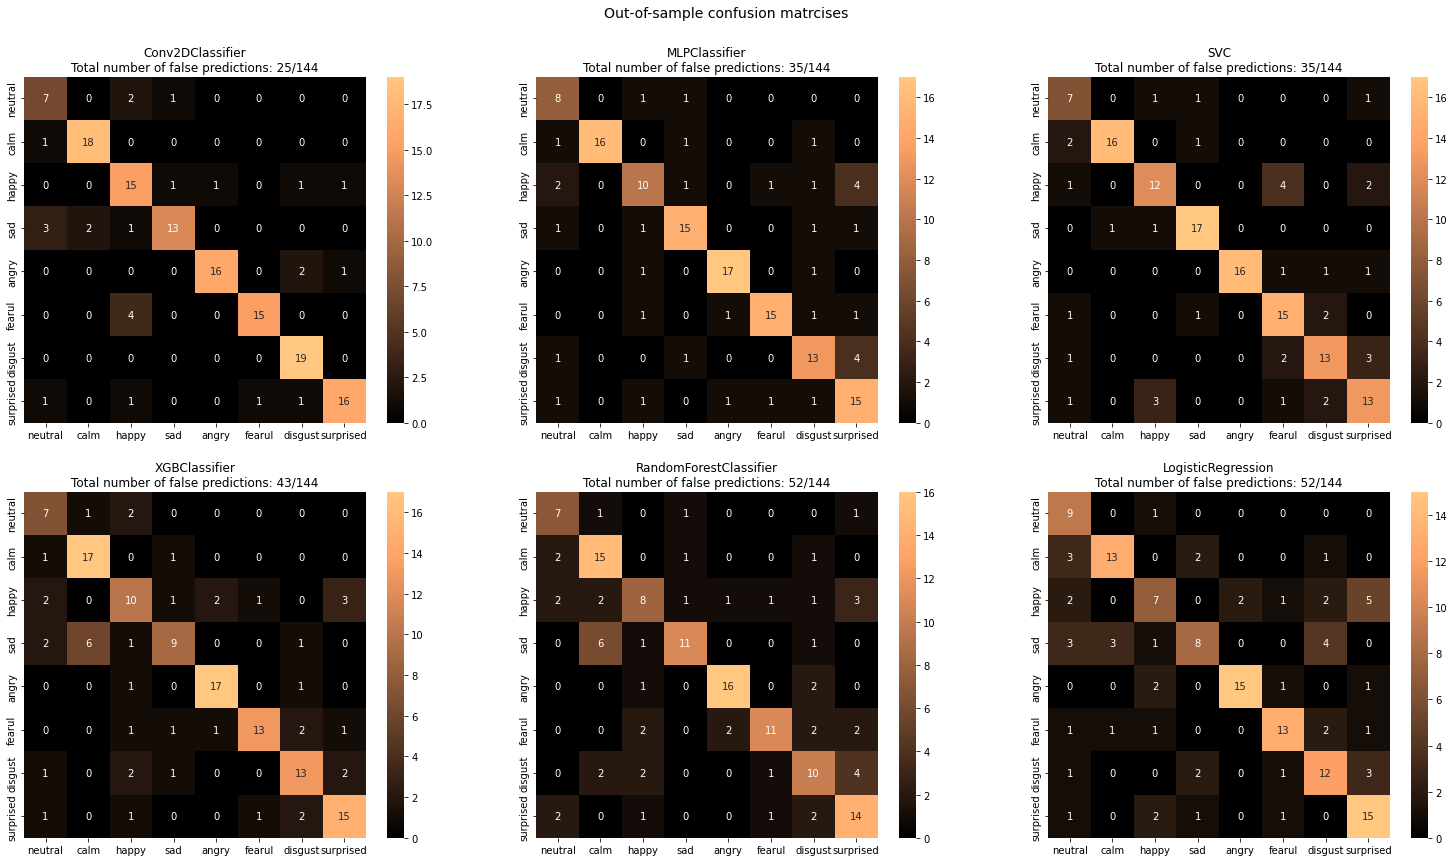


========= Evaluation ==========

With estimator: Conv2DClassifier

F1-score: 0.816
Accuracy: 0.826

============ END ==============


========= Evaluation ==========

With estimator: MLPClassifier

F1-score: 0.755
Accuracy: 0.757

============ END ==============


========= Evaluation ==========

With estimator: SVC

F1-score: 0.752
Accuracy: 0.757

============ END ==============


========= Evaluation ==========

With estimator: XGBClassifier

F1-score: 0.691
Accuracy: 0.701

============ END ==============


========= Evaluation ==========

With estimator: RandomForestClassifier

F1-score: 0.636
Accuracy: 0.639

============ END ==============


========= Evaluation ==========

With estimator: LogisticRegression

F1-score: 0.634
Accuracy: 0.639

============ END ==============



In [10]:
X_test, y_test = joblib.load('data/X_test'), joblib.load('data/y_test')
X_train_keras, X_test_keras = joblib.load('data/X_train_keras'), joblib.load('data/X_test_keras')

names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']

target_labels = ['neutral',
                 'calm',
                 'happy',
                 'sad',
                 'angry',
                 'fearul',
                 'disgust',
                 'surprised']

clfs = [joblib.load('models/'+name) for name in names]

temp = [(name, clf.predict(X_test), f1_score(y_test, clf.predict(X_test), average='macro')) for clf, name in zip(clfs, names)]

clf_keras = keras.models.load_model('models/OptimizedConv2DClassifier.h5')

X_train_keras[1], X_test_keras[1] = scaler(X_train_keras[1], X_test_keras[1])

y_pred_keras = np.argmax(clf_keras.predict([X_test_keras[0], X_test_keras[1], X_test_keras[2]]), axis=-1)
f1_keras = f1_score(y_test, y_pred_keras, average='macro')

temp.append(('Conv2DClassifier', y_pred_keras, f1_keras))

sorted_clfs = sorted(temp, key=lambda x: x[2], reverse=True)

fig, axs = plt.subplots(2, 3, figsize=(26,14))

axlist = axs.flatten()

for ax, (name, y_pred, f1) in zip(axlist, sorted_clfs):
    
    cm = confusion_matrix(y_test, y_pred)
    fp = cm.sum(axis=0) - np.diag(cm)  
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=target_labels, yticklabels=target_labels)
    ax.set_title(f'{name}\nTotal number of false predictions: {sum(fp)}/{len(y_test)}')
    
plt.suptitle('Out-of-sample confusion matrcises', fontsize=14, y=0.95)
plt.show()

for name, y_pred, f1 in sorted_clfs:

    print('\n========= Evaluation ==========\n')
    print(f'With estimator: {name}\n')
    print(f"F1-score: {round(f1, 3)}")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}\n")
    print('============ END ==============\n')